<a href="https://colab.research.google.com/github/Jinukki/KJU/blob/master/Ch9_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 09-4 LSTM 순환 신경망을 만들고 텍스트를 분류합니다.

##### 앞에서 그레디언트가 전파될 때 가중치가 반복하여 곱해지므로 그레디언트가 크게 증가 혹은 감소한다고 하였다. 이를 해결하기 위해 가장 간단한 방법인 TSBTT를 구현하였는데 이 방법은 그레디언트가 타임 스텝 끝까지 전파되지 않으므로 타임 스텝이 멀리 떨어진 영단어 사이의 관계를 파악하기 어렵다. 이런 경우 좀 더 긴 타임 스텝 데이터를 처리하는 LSTM(LongShort-Term Memory) 순환 신경망을 사용한다.

In [0]:
!pip install tensorflow_gpu==2.0.0-rc1

In [0]:
import tensorflow as tf
tf.__version__

'2.0.0-rc1'

---
> ### LSTM 셀의 구조를 알아봅시다.
##### 기본 순환 신경망과 달리 2개의 출력이 순환되는데 그 중 하나만 다음 층으로 전달된다. 셀로 순환만 되는 출력을 셀 상태(C)라고 부른다.

![18](https://user-images.githubusercontent.com/52277776/69024434-12389100-0a06-11ea-8232-9db47805a80f.jpg)

##### LSTM 셀에서 이전 타임 스텝의 은닉상태 $H_p$와 셀 상태 $C_p$를 사용해 어떤 계산을 수행하는지 셀을 크게 확대하여 그려보자.

![19](https://user-images.githubusercontent.com/52277776/69024436-149aeb00-0a06-11ea-849a-37c38fe37d8b.jpg)

##### s, t는 각각 시그모이드와 tanh 활성화 함수를 의미한다. x 및 + 는 각각 원소별 곱셈과 덧셈을 의미한다. 맨 아래쪽을 보면 $H_{p}$와 $X$가 가중치와 곱해져 아래 예와 같이 $Z_{f},Z_{i},Z_{j},Z_{o}$를 만든다.
<br>
$$Z_{f}=XW_{xf}+H_{p}W_{hf}+b_f$$<br>

##### 각각의 $Z$항은 모두 다른 가중치, 즉 $W_{xi},W_{hi},b_{i},W_{xj},W_{hj},b_{j},W_{xo},W_{ho},b_{o}$ 를 사용하여 계산한다. 계산 후 각 $Z$에 시그모이드나 tanh 활성화 함수를 적용한 뒤 요소별 곱셈을 통한 계산과정을 진행한다. 이 과정을 나타내는 전체 공식은 다음과 같다.
<br>
$$F=C_{p}\times sigmoid(Z_{f})$$
$$I=sigmoid(Z_{i})\times tanh(Z_{j})$$
$$C=F+I$$
$$H=tanh(C)\times sigmoid(Z_{o})$$<br>

##### F계산식이 이전 셀 상태의 내용을 삭제하는 역할을 한다고 하여 삭제 게이트(forget gate)라고 부른다. I계산식은 새로운 정보를 추가하는 역할이라는 뜻에서 입력 게이트(input gate)라고 부른다. 마지막 H를 계산하는 식을 출력 게이트(output gate)라고 부른다. 하지만 게이트의 역할은 데이터 세트나 상황에 따라 달라질 수 있다. 이처럼 LSTM 셀은 꽤 복잡한 구조이지만 텐서플로를 통해 간단히 구현 가능하다.

---
> ### 텐서플로로 LSTM 순환 신경망 만들기
##### 09-3절에서 이용한 SimpleRNN 클래스를 LSTM 클래스로 바꾸기만 하면 LSTM 순환 신경망을 만들 수 있다.

##### 먼저 LSTM 클래스를 임포트하고 임베딩층을 포함하여 LSTM 순환 신경망을 만든다.

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

model_lstm = Sequential()

model_lstm.add(Embedding(1000,32))
model_lstm.add(LSTM(8))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          32000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 1312      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 33,321
Trainable params: 33,321
Non-trainable params: 0
_________________________________________________________________


##### 여기에서도 10번의 에포크 동안 Adam 최적화 알고리즘을 사용하여 모델을 훈련하자.

In [0]:
from tensorflow.keras.datasets import imdb
(x_train_all, y_train_all), (x_test, y_test)=imdb.load_data(skip_top=20, num_words=1000)
# 앞과 마찬가지로 단어 1000개

for i in range(len(x_train_all)):
  x_train_all[i]=[w for w in x_train_all[i] if w>2]

import numpy as np
np.random.seed(42)
random_index=np.random.permutation(25000)

x_train=x_train_all[random_index[:20000]]
y_train=y_train_all[random_index[:20000]]
x_val=x_train_all[random_index[20000:]]
y_val=y_train_all[random_index[20000:]]



In [0]:
from tensorflow.keras.preprocessing import sequence

maxlen=100
x_train_seq = sequence.pad_sequences(x_train, maxlen=maxlen)
x_val_seq = sequence.pad_sequences(x_val, maxlen=maxlen)

In [0]:
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# 원-핫 인코딩 적용하지 않음
history=model_lstm.fit(x_train_seq, y_train, epochs=10, batch_size=32, validation_data=(x_val_seq, y_val))

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 27s 1ms/sample - loss: 0.4440 - accuracy: 0.7940 - val_loss: 0.3720 - val_accuracy: 0.8406
Epoch 2/10
20000/20000 [==============================] - 25s 1ms/sample - loss: 0.3371 - accuracy: 0.8578 - val_loss: 0.3604 - val_accuracy: 0.8392
Epoch 3/10
20000/20000 [==============================] - 24s 1ms/sample - loss: 0.3168 - accuracy: 0.8683 - val_loss: 0.3634 - val_accuracy: 0.8410
Epoch 4/10
20000/20000 [==============================] - 25s 1ms/sample - loss: 0.3040 - accuracy: 0.8711 - val_loss: 0.3622 - val_accuracy: 0.8386
Epoch 5/10
20000/20000 [==============================] - 25s 1ms/sample - loss: 0.2928 - accuracy: 0.8774 - val_loss: 0.3735 - val_accuracy: 0.8420
Epoch 6/10
20000/20000 [==============================] - 24s 1ms/sample - loss: 0.2805 - accuracy: 0.8839 - val_loss: 0.3737 - val_accuracy: 0.8406
Epoch 7/10
20000/20000 [==============================] -

##### 손실과 정확도를 그래프로 그려보자

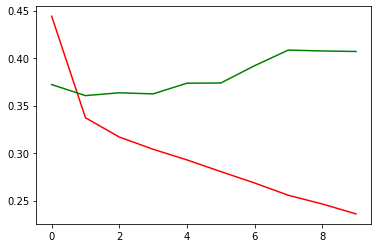

In [0]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], color='red')
plt.plot(history.history['val_loss'], color='green')
plt.show()

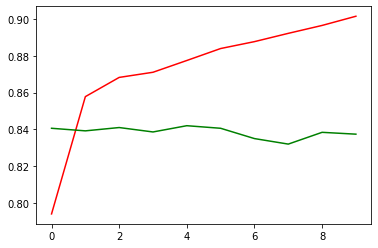

In [0]:
plt.plot(history.history['accuracy'], color='red')
plt.plot(history.history['val_accuracy'], color='green')
plt.show()

##### 검증 세트의 정확도를 평가해 보자. 성능이 더 향상된 것을 확인할 수 있다.

In [0]:
loss, accuracy = model_lstm.evaluate(x_val_seq, y_val, verbose=0)
print(accuracy)

0.8374


##### 지금까지 순환 신경망의 구조와 역전파 방법을 공부하고 파이썬과 텐서플로를 사용하여 순환 신경망을 구축하고 훈련시켜 보았다.